In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             3222 non-null   float64
 1   bath            3222 non-null   float64
 2   acre_lot        3222 non-null   float64
 3   zip_code        3222 non-null   float64
 4   house_size      3222 non-null   float64
 5   prev_sold_date  3222 non-null   object 
 6   price           3222 non-null   float64
dtypes: float64(6), object(1)
memory usage: 176.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3222 entries, 0 to 3221
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             3222 non-null   float64
 1   bath            3222 non-null   float64
 2   acre_lot        3222 non-null   float64
 3   zip_code        3222 non-null   float64
 4   house_size      3222 non-null   float64
 5   price           3222 non-null   float64
 6   prev_sold_year  3222 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 176.3 KB


In [5]:
outliers_df["zip_code_str"] = np.where(outliers_df.zip_code.apply(int) < 10000,'0'+ outliers_df.zip_code.apply(int).apply(str),outliers_df.zip_code.apply(int).apply(str))
outliers_df.head()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,zip_code_str
0,3.0,2.0,0.14,7001.0,1542.0,305100.0,2022,07001
1,3.0,2.0,0.17,7001.0,7501.0,340000.0,2021,07001
2,5.0,2.0,0.18,7001.0,1387.0,484000.0,2020,07001
3,4.0,4.0,0.06,7001.0,2296.0,525000.0,2017,07001
4,3.0,1.0,0.17,7001.0,1008.0,325000.0,2022,07001


In [6]:
zip_lon_lat = pd.read_csv('nj_zip-lon-lat.csv')
zip_lon_lat["zip_code_str"] = np.where(zip_lon_lat.zip_code.apply(int) < 10000,'0'+ zip_lon_lat.zip_code.apply(int).apply(str),zip_lon_lat.zip_code.apply(int).apply(str))
zip_lon_lat.head()

,zip_code,latitude,longitude,zip_code_str
0,7001,40.582316,-74.271506,07001
1,7002,40.662338,-74.110275,07002
2,7003,40.809128,-74.187155,07003
3,7004,40.882508,-74.304593,07004
4,7005,40.932771,-74.417304,07005


In [7]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code_str")

merged_df.tail()

,bed,bath,acre_lot,zip_code_x,house_size,price,prev_sold_year,zip_code_str,zip_code_y,latitude,longitude
3214,6.0,2.0,0.26,8865.0,2974.0,299000.0,2017,08865,8865,40.708223,-75.147074
3215,4.0,2.0,0.15,8865.0,1500.0,179000.0,2021,08865,8865,40.708223,-75.147074
3216,4.0,4.0,0.19,7661.0,4935.0,1275000.0,2017,07661,7661,40.927354,-74.039611
3217,4.0,3.0,0.20,7514.0,2535.0,529000.0,2021,07514,7514,40.926992,-74.143838
3218,3.0,4.0,0.12,7072.0,1744.0,599000.0,2020,07072,7072,40.826424,-74.062338


In [8]:
features = ["latitude","longitude","bed","bath","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

In [9]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [10]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[]}
def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [11]:
params = {'min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
         'max_depth': [2, 5, 10],
         'min_samples_split': [0.1, 0.2, 0.05],
         'random_state':[42]}

grid = GridSearchCV(DecisionTreeRegressor().fit(X_train, y_train), param_grid=params).fit(X_train, y_train)
grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_
best_params

{'max_depth': 10,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'random_state': 42}

In [12]:
dtree = DecisionTreeRegressor(**best_params)
dtree_model = dtree.fit(X_train,y_train)
dtree_predict = dtree_model.predict(X_test)
dtree_mse = mean_squared_error(y_test,dtree_predict)
print_more_stuff("Decision Tree", y_test, dtree_predict)

Decision Tree EVS = 0.578388779
Decision Tree MSE = 75,547,425,232.182022
Decision Tree MAE = 150,241.731162
Decision Tree R2 = 0.578322


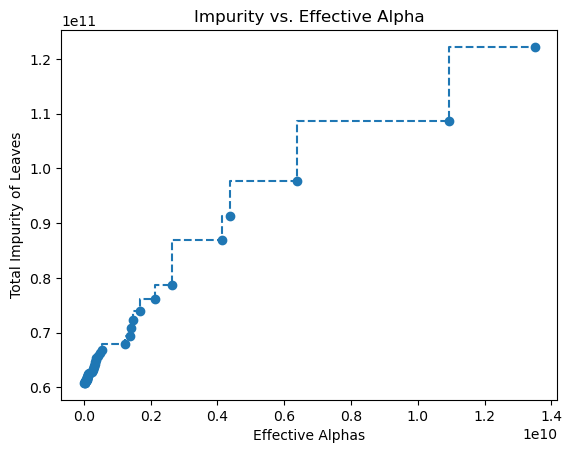

In [13]:
path = dtree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.step(ccp_alphas[:-1], impurities[:-1], '--o')
plt.title('Impurity vs. Effective Alpha')
plt.xlabel('Effective Alphas')
plt.ylabel('Total Impurity of Leaves');

In [14]:
dtree_rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_rfe.fit(X, y)
dtree_rfe_selected_features = dtree_rfe.get_support()
print('The selected features are:', list(X.columns[dtree_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']


In [15]:
X_rfe = merged_df[list(X.columns[dtree_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [16]:
dtree_rfe = DecisionTreeRegressor()
dtree_rfe_model = dtree_rfe.fit(X_rfe_train,y_rfe_train)
dtree_rfe_predict = dtree_rfe_model.predict(X_rfe_test)
dtree_rfe_mse = mean_squared_error(y_rfe_test,dtree_rfe_predict)
print_more_stuff("Recursive Feature Elimination", y_rfe_test, dtree_rfe_predict)

Recursive Feature Elimination EVS = 0.542463981
Recursive Feature Elimination MSE = 81,992,615,345.965958
Recursive Feature Elimination MAE = 158,054.949767
Recursive Feature Elimination R2 = 0.542347


In [17]:
dtree_sfs = SequentialFeatureSelector(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_sfs.fit(X, y)
dtree_sfs_selected_features = dtree_sfs.get_support()
print('The selected features are:', list(X.columns[dtree_sfs_selected_features]))

The selected features are: ['latitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [18]:
X_sfs = merged_df[list(X.columns[dtree_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [19]:
dtree_sfs = DecisionTreeRegressor()
dtree_sfs_model = dtree_sfs.fit(X_sfs_train,y_sfs_train)
dtree_sfs_predict = dtree_sfs_model.predict(X_sfs_test)
dtree_sfs_mse = mean_squared_error(y_sfs_test,dtree_sfs_predict)

print_more_stuff("Sequential Feature Selector", y_sfs_test, dtree_sfs_predict)

Sequential Feature Selector EVS = 0.317712689
Sequential Feature Selector MSE = 122,406,680,902.589096
Sequential Feature Selector MAE = 186,110.216097
Sequential Feature Selector R2 = 0.316771


In [20]:
dtree_predict_df = pd.DataFrame(dtree_predict).reset_index()
dtree_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()


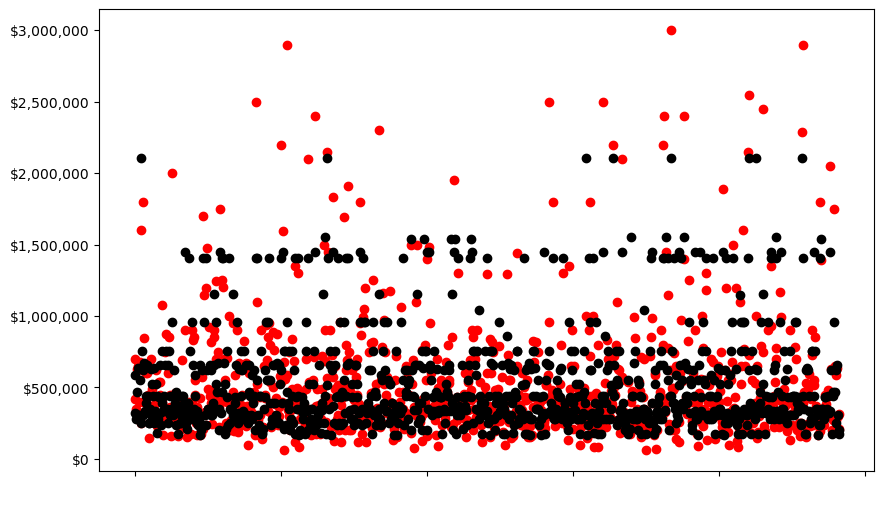

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_predict_df.index,dtree_predict_df["prediction"], color="black")
plt.show()

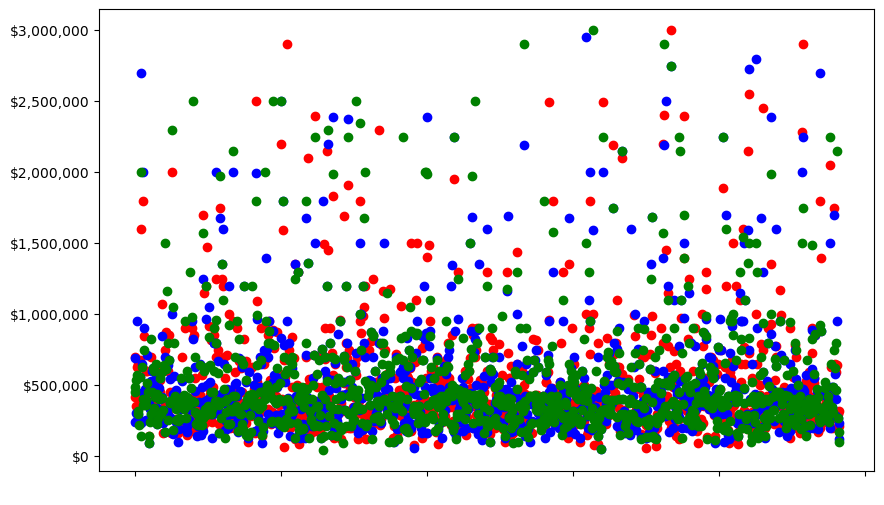

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.show()

In [23]:
results_dict

{'model': ['Decision Tree',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.578388779', '0.542463981', '0.317712689'],
 'mae score': ['150,241.731162', '158,054.949767', '186,110.216097'],
 'mse score': ['75,547,425,232.182022',
  '81,992,615,345.965958',
  '122,406,680,902.589096'],
 'r2 score': ['0.578322', '0.542347', '0.316771']}

In [24]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score
model,,,,
Decision Tree,0.578388779,"150,241.731162","75,547,425,232.182022",0.578322
Recursive Feature Elimination,0.542463981,"158,054.949767","81,992,615,345.965958",0.542347
Sequential Feature Selector,0.317712689,"186,110.216097","122,406,680,902.589096",0.316771
